# Lead changes

Exploring how many times the lead changes in all regular-season games

## Data organisation

As usual, we have one folder per competition, within which we have one folder per season. We will have two variables `comp` and `season` to specify which files we want to use.

Here, `season` will refer to the 'current' season, and we will always compare that season with the preceeding one.

We will analyse several instances, so we have two lists `comps` and `seasons`, and `comp` and `season` will iterate over these two lists.

In [2]:
!ls ../opta_data/Mens/

AutumnNationsCup        NPC                     SuperRugbyAU
ChallengeCup            PacificNationsCup       SuperRugbyAotearoa
ChampionsCup            Premiership             SuperRugbyPacific
CurrieCup               ProD2                   SuperRugbyTranstasman
International           RWC                     TRC
JapanRugbyLeagueOneD1   RainbowCup              Top14
JapanTopLeague          RainbowCupSA            URC
Lions                   RugbyEuropeChampionship
MLR                     SixNations


In [3]:
comps = ["SuperRugbyPacific", "Top14", "URC"]
seasons = [23, 24, 25]

## Support functions

In [5]:
from ast import literal_eval

def process_one_game(filename):
    with open(filename,'r') as inFile:
        lines = inFile.readlines()

    # Read the header line
    header = lines[0].strip().split(',')
    
    # Determine the index for all the columns we want to use
    hometeamCurrentScore = header.index('hometeamCurrentScore')
    awayteamCurrentScore = header.index('awayteamCurrentScore')
    MatchTime = header.index('MatchTime')
    period = header.index('period')

    last_change = "1_00000"

    score_difference = 0
    lead_changes = 0
    max_pos = 0
    max_neg = 0
    max_lead_for_losing_side = 0

    # Process all lines
    for i in range(1,len(lines)):
        temp_array = lines[i].strip().split(',')

        # we extract the score and calculate the point differential
        home_score = literal_eval(temp_array[hometeamCurrentScore])
        away_score = literal_eval(temp_array[awayteamCurrentScore])
        new_diff = home_score-away_score

        # we update the min/max differentials
        if new_diff>max_pos:
            max_pos = new_diff
        if new_diff<0 and abs(new_diff)>abs(max_neg):
            max_neg = new_diff

        if home_score=="":
            continue

        # we extract the current time and calculate the offset for the interval arrays
        game_period = temp_array[period]
        game_clock = temp_array[MatchTime].zfill(5)
        time = f"{game_period}_{game_clock}"

        # we check if the lead has changed
        if new_diff!=score_difference:
            if score_difference==0:
                lead_changes+=1
                last_change = time
            elif new_diff*score_difference<=0: # if the product is negative, the values have opposite signs
                lead_changes+=1
                last_change = time
        score_difference=new_diff

    if score_difference>0:
        max_lead_for_losing_side = abs(max_neg)
    elif score_difference<0:
        max_lead_for_losing_side = max_pos
    else:
        max_lead_for_losing_side = max(max_pos, abs(max_neg))
    
    return lead_changes, last_change, abs(score_difference), max_lead_for_losing_side

## Process all seasons

In [7]:
import glob

def check_duplicates(my_list):
    seen = set()
    for x in my_list:
        if x in seen:
            print(f"Game {x} has been seen before")
        seen.add(x)

round_limits = {"SuperRugbyPacific": 15,
                "Top14": 26,
                "URC": 18
               }

lead_changes = dict()
last_change_times = dict()
final_score_difference = dict()
max_lead_for_losing_sides = dict()

for comp in comps:
    for s in seasons:
        season = f"20{s-1}-{s}"
        print(f"Extracting the {season} season for {comp}")

        if comp not in lead_changes:
            lead_changes[comp] = dict()
            last_change_times[comp] = dict()
            final_score_difference[comp] = dict()
            max_lead_for_losing_sides[comp] = dict()

        if season not in lead_changes[comp]:
            lead_changes[comp][season] = []
            last_change_times[comp][season] = []
            final_score_difference[comp][season] = []
            max_lead_for_losing_sides[comp][season] = []
        
        list_games = []
        for rd in range(0,round_limits[comp]):
            round_games = glob.glob(f"../opta_data/Mens/{comp}/{season}/Round_{rd+1}/*.csv",recursive=True)
            list_games += round_games
        
        print(f"{len(list_games)} games to process.")
        check_duplicates(list_games)

        for f in list_games:
            changes, last_change, final_diff, max_lead = process_one_game(f)
            lead_changes[comp][season].append(changes)
            last_change_times[comp][season].append(last_change)
            final_score_difference[comp][season].append(final_diff)
            max_lead_for_losing_sides[comp][season].append(max_lead)


Extracting the 2022-23 season for SuperRugbyPacific
84 games to process.
Extracting the 2023-24 season for SuperRugbyPacific
84 games to process.
Extracting the 2024-25 season for SuperRugbyPacific
25 games to process.
Extracting the 2022-23 season for Top14
182 games to process.
Extracting the 2023-24 season for Top14
182 games to process.
Extracting the 2024-25 season for Top14
105 games to process.
Extracting the 2022-23 season for URC
144 games to process.
Extracting the 2023-24 season for URC
144 games to process.
Extracting the 2024-25 season for URC
77 games to process.


## Analysis

### Number of lead changes

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, mannwhitneyu, iqr


# Step 1: Compute summary statistics
summary_stats = []
for competition, all_seasons in lead_changes.items():
    for season, values in all_seasons.items():
        summary_stats.append({
            "Competition": competition,
            "Season": season,
            "Min": np.min(values),
            "Max": np.max(values),
            "Mean": round(np.mean(values), 2),
            "Median": round(np.median(values), 2),
            "StdDev": round(np.std(values, ddof=1), 2),
            "IQR": round(iqr(values), 2),
        })

df_summary = pd.DataFrame(summary_stats)
print(df_summary)

# Step 2: Compare distributions between seasons
comparisons = []
seasons_list = [(comp, season, values) for comp, all_seasons in lead_changes.items() for season, values in all_seasons.items()]

for i in range(len(seasons_list)):
    for j in range(i + 1, len(seasons_list)):
        comp1, season1, values1 = seasons_list[i]
        comp2, season2, values2 = seasons_list[j]

        # Kolmogorov-Smirnov test (non-parametric)
        ks_stat, ks_p = ks_2samp(values1, values2)

        # Mann-Whitney U test (non-parametric)
        mw_stat, mw_p = mannwhitneyu(values1, values2, alternative='two-sided')

        comparisons.append({
            "Comparison": f"{comp1}-{season1} vs {comp2}-{season2}",
            "KS_p_value": round(ks_p, 4),
            "MWU_p_value": round(mw_p, 4)
        })

df_comparisons = pd.DataFrame(comparisons)
print(df_comparisons)


         Competition   Season  Min  Max  Mean  Median  StdDev  IQR
0  SuperRugbyPacific  2022-23    1   12  3.82     3.0    2.62  4.0
1  SuperRugbyPacific  2023-24    1   18  3.20     3.0    2.80  3.0
2  SuperRugbyPacific  2024-25    1   10  4.88     5.0    2.40  4.0
3              Top14  2022-23    1   12  3.33     3.0    2.19  4.0
4              Top14  2023-24    1   11  3.01     3.0    2.15  3.0
5              Top14  2024-25    1    9  3.24     3.0    2.06  4.0
6                URC  2022-23    1    8  2.86     3.0    1.86  3.0
7                URC  2023-24    1   10  3.06     3.0    1.92  3.0
8                URC  2024-25    1   12  3.09     3.0    2.26  3.0
                                           Comparison  KS_p_value  MWU_p_value
0   SuperRugbyPacific-2022-23 vs SuperRugbyPacific...      0.0949       0.0557
1   SuperRugbyPacific-2022-23 vs SuperRugbyPacific...      0.1909       0.0424
2          SuperRugbyPacific-2022-23 vs Top14-2022-23      0.4988       0.2260
3          Sup

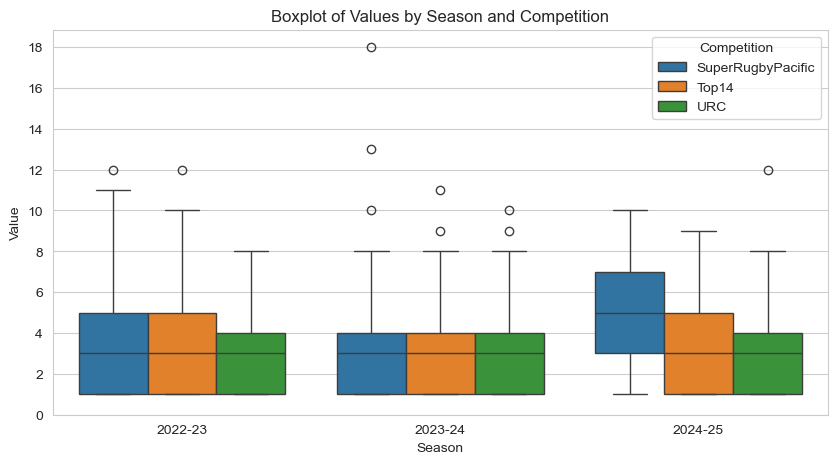

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert data into a DataFrame for visualization
plot_data = []
for competition, all_seasons in lead_changes.items():
    for season, values in all_seasons.items():
        for value in values:
            plot_data.append({"Competition": competition, "Season": season, "Value": value})

df_plot = pd.DataFrame(plot_data)

# Set plot style
sns.set_style("whitegrid")

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x="Season", y="Value", hue="Competition", data=df_plot)
plt.title("Boxplot of Values by Season and Competition")

min_val = int(df_plot["Value"].min())
max_val = int(df_plot["Value"].max())
plt.yticks(range(0, max_val + 1, 2))

plt.xlabel("Season")
plt.ylabel("Value")
plt.legend(title="Competition")
plt.show()


#### Games with no lead change

In [12]:
for comp in comps:
    print(f"\n{comp}")
    for s in seasons:
        season = f"20{s-1}-{s}"
        print(f"\n{season}")

        nb_games = len(lead_changes[comp][season])
        nb_no_change = 0

        for g in range(0,nb_games):
            
            if lead_changes[comp][season][g]<=1:
                nb_no_change+=1

        print("Total games: ",nb_games)
        print(f"Games with no lead change: {nb_no_change} ({round(nb_no_change/nb_games*100,2)}%)")
        


SuperRugbyPacific

2022-23
Total games:  84
Games with no lead change: 23 (27.38%)

2023-24
Total games:  84
Games with no lead change: 30 (35.71%)

2024-25
Total games:  25
Games with no lead change: 3 (12.0%)

Top14

2022-23
Total games:  182
Games with no lead change: 53 (29.12%)

2023-24
Total games:  182
Games with no lead change: 68 (37.36%)

2024-25
Total games:  105
Games with no lead change: 30 (28.57%)

URC

2022-23
Total games:  144
Games with no lead change: 56 (38.89%)

2023-24
Total games:  144
Games with no lead change: 39 (27.08%)

2024-25
Total games:  77
Games with no lead change: 29 (37.66%)


### Number of changes later in games

In [14]:
for comp in comps:
    print(f"\n{comp}")
    for s in seasons:
        season = f"20{s-1}-{s}"
        print(f"\n{season}")

        nb_games = len(last_change_times[comp][season])
        nb_change_second_half = 0
        nb_change_after70 = 0
        nb_change_after75 = 0

        for g in range(0,nb_games):

            period, time = last_change_times[comp][season][g].split("_")
            minutes = literal_eval(time[0:3].lstrip("0"))
            
            if period=="2":
                nb_change_second_half+=1
                if minutes>=70:
                    nb_change_after70+=1
                if minutes>=75:
                    nb_change_after75+=1
            elif period=="3":
                nb_change_second_half+=1
                nb_change_after70+=1
                nb_change_after75+=1

        print("Total games: ",nb_games)
        print(f"Lead changes after the first half: {nb_change_second_half} ({round(nb_change_second_half/nb_games*100,2)}%)")
        print(f"Lead changes after 70 minutes: {nb_change_after70} ({round(nb_change_after70/nb_games*100,2)}%)")
        print(f"Lead changes after 75 minutes: {nb_change_after75} ({round(nb_change_after75/nb_games*100,2)}%)")
                



SuperRugbyPacific

2022-23
Total games:  84
Lead changes after the first half: 33 (39.29%)
Lead changes after 70 minutes: 13 (15.48%)
Lead changes after 75 minutes: 10 (11.9%)

2023-24
Total games:  84
Lead changes after the first half: 33 (39.29%)
Lead changes after 70 minutes: 10 (11.9%)
Lead changes after 75 minutes: 9 (10.71%)

2024-25
Total games:  25
Lead changes after the first half: 17 (68.0%)
Lead changes after 70 minutes: 9 (36.0%)
Lead changes after 75 minutes: 6 (24.0%)

Top14

2022-23
Total games:  182
Lead changes after the first half: 80 (43.96%)
Lead changes after 70 minutes: 30 (16.48%)
Lead changes after 75 minutes: 20 (10.99%)

2023-24
Total games:  182
Lead changes after the first half: 65 (35.71%)
Lead changes after 70 minutes: 31 (17.03%)
Lead changes after 75 minutes: 21 (11.54%)

2024-25
Total games:  105
Lead changes after the first half: 49 (46.67%)
Lead changes after 70 minutes: 17 (16.19%)
Lead changes after 75 minutes: 14 (13.33%)

URC

2022-23
Total games

### Distribution of score differential

In [16]:
# Step 1: Compute summary statistics
summary_stats = []
for competition, all_seasons in final_score_difference.items():
    for season, values in all_seasons.items():
        summary_stats.append({
            "Competition": competition,
            "Season": season,
            "Min": np.min(values),
            "Max": np.max(values),
            "Mean": round(np.mean(values), 2),
            "Median": round(np.median(values), 2),
            "StdDev": round(np.std(values, ddof=1), 2),
            "IQR": round(iqr(values), 2),
        })

df_summary = pd.DataFrame(summary_stats)
print(df_summary)

# Step 2: Compare distributions between seasons
comparisons = []
seasons_list = [(comp, season, values) for comp, all_seasons in final_score_difference.items() for season, values in all_seasons.items()]

for i in range(len(seasons_list)):
    for j in range(i + 1, len(seasons_list)):
        comp1, season1, values1 = seasons_list[i]
        comp2, season2, values2 = seasons_list[j]

        # Kolmogorov-Smirnov test (non-parametric)
        ks_stat, ks_p = ks_2samp(values1, values2)

        # Mann-Whitney U test (non-parametric)
        mw_stat, mw_p = mannwhitneyu(values1, values2, alternative='two-sided')

        comparisons.append({
            "Comparison": f"{comp1}-{season1} vs {comp2}-{season2}",
            "KS_p_value": round(ks_p, 4),
            "MWU_p_value": round(mw_p, 4)
        })

df_comparisons = pd.DataFrame(comparisons)
print(df_comparisons)

         Competition   Season  Min  Max   Mean  Median  StdDev    IQR
0  SuperRugbyPacific  2022-23    1   59  16.12    13.5   12.69  16.25
1  SuperRugbyPacific  2023-24    0   56  16.83    13.0   13.96  21.25
2  SuperRugbyPacific  2024-25    1   24   9.36     5.0    8.46  15.00
3              Top14  2022-23    0   49  12.98    10.0   11.04  14.00
4              Top14  2023-24    0   56  13.30    10.0   11.12  15.50
5              Top14  2024-25    0   52  12.81     9.0   11.19  15.00
6                URC  2022-23    0   64  15.44    14.0   12.35  16.00
7                URC  2023-24    0   53  13.90    10.0   12.23  18.00
8                URC  2024-25    0   43  12.04     9.0   10.39  16.00
                                           Comparison  KS_p_value  MWU_p_value
0   SuperRugbyPacific-2022-23 vs SuperRugbyPacific...      0.9347       0.9734
1   SuperRugbyPacific-2022-23 vs SuperRugbyPacific...      0.0227       0.0117
2          SuperRugbyPacific-2022-23 vs Top14-2022-23      0.13

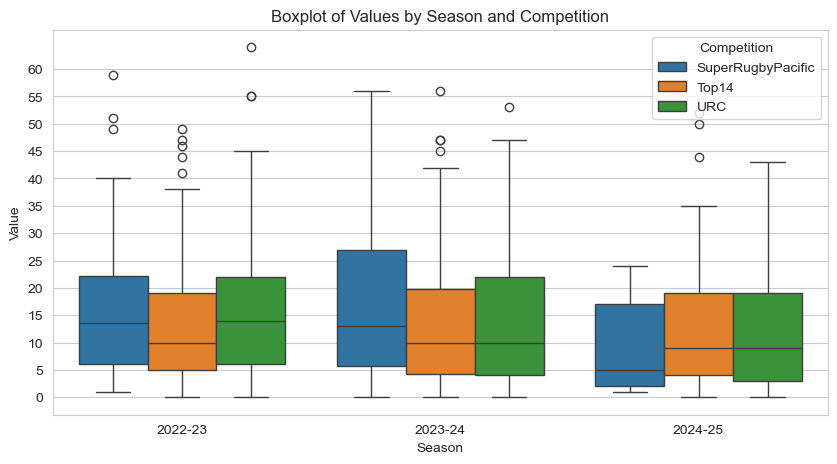

In [17]:
# Convert data into a DataFrame for visualization
plot_data = []
for competition, all_seasons in final_score_difference.items():
    for season, values in all_seasons.items():
        for value in values:
            plot_data.append({"Competition": competition, "Season": season, "Value": value})

df_plot = pd.DataFrame(plot_data)

# Set plot style
sns.set_style("whitegrid")

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x="Season", y="Value", hue="Competition", data=df_plot)
plt.title("Boxplot of Values by Season and Competition")

min_val = int(df_plot["Value"].min())
max_val = int(df_plot["Value"].max())
plt.yticks(range(0, max_val + 1, 5))

plt.xlabel("Season")
plt.ylabel("Value")
plt.legend(title="Competition")
plt.show()


In [18]:
for comp in comps:
    print(f"\n{comp}")
    for s in seasons:
        season = f"20{s-1}-{s}"
        print(f"\n{season}")

        nb_games = len(final_score_difference[comp][season])
        nb_within_7 = 0
        nb_within_3 = 0
        nb_above_25 = 0

        for g in range(0,nb_games):
            
            if final_score_difference[comp][season][g]<=7:
                nb_within_7+=1

            if final_score_difference[comp][season][g]<=3:
                nb_within_3+=1

            if final_score_difference[comp][season][g]>=25:
                nb_above_25+=1

        print("Total games: ",nb_games)
        print(f"Games finishing within 7 points: {nb_within_7} ({round(nb_within_7/nb_games*100,2)}%)")
        print(f"Games finishing within 3 points: {nb_within_3} ({round(nb_within_3/nb_games*100,2)}%)")
        print(f"Games finishing with 25+ differential: {nb_above_25} ({round(nb_above_25/nb_games*100,2)}%)")



SuperRugbyPacific

2022-23
Total games:  84
Games finishing within 7 points: 27 (32.14%)
Games finishing within 3 points: 13 (15.48%)
Games finishing with 25+ differential: 17 (20.24%)

2023-24
Total games:  84
Games finishing within 7 points: 27 (32.14%)
Games finishing within 3 points: 15 (17.86%)
Games finishing with 25+ differential: 24 (28.57%)

2024-25
Total games:  25
Games finishing within 7 points: 13 (52.0%)
Games finishing within 3 points: 8 (32.0%)
Games finishing with 25+ differential: 0 (0.0%)

Top14

2022-23
Total games:  182
Games finishing within 7 points: 77 (42.31%)
Games finishing within 3 points: 29 (15.93%)
Games finishing with 25+ differential: 30 (16.48%)

2023-24
Total games:  182
Games finishing within 7 points: 72 (39.56%)
Games finishing within 3 points: 33 (18.13%)
Games finishing with 25+ differential: 27 (14.84%)

2024-25
Total games:  105
Games finishing within 7 points: 44 (41.9%)
Games finishing within 3 points: 20 (19.05%)
Games finishing with 25+ di

### Distribution of reversed leads

In [20]:
# Step 1: Compute summary statistics
summary_stats = []
for competition, all_seasons in max_lead_for_losing_sides.items():
    for season, values in all_seasons.items():
        summary_stats.append({
            "Competition": competition,
            "Season": season,
            "Min": np.min(values),
            "Max": np.max(values),
            "Mean": round(np.mean(values), 2),
            "Median": round(np.median(values), 2),
            "StdDev": round(np.std(values, ddof=1), 2),
            "IQR": round(iqr(values), 2),
        })

df_summary = pd.DataFrame(summary_stats)
print(df_summary)

# Step 2: Compare distributions between seasons
comparisons = []
seasons_list = [(comp, season, values) for comp, all_seasons in max_lead_for_losing_sides.items() for season, values in all_seasons.items()]

for i in range(len(seasons_list)):
    for j in range(i + 1, len(seasons_list)):
        comp1, season1, values1 = seasons_list[i]
        comp2, season2, values2 = seasons_list[j]

        # Kolmogorov-Smirnov test (non-parametric)
        ks_stat, ks_p = ks_2samp(values1, values2)

        # Mann-Whitney U test (non-parametric)
        mw_stat, mw_p = mannwhitneyu(values1, values2, alternative='two-sided')

        comparisons.append({
            "Comparison": f"{comp1}-{season1} vs {comp2}-{season2}",
            "KS_p_value": round(ks_p, 4),
            "MWU_p_value": round(mw_p, 4)
        })

df_comparisons = pd.DataFrame(comparisons)
print(df_comparisons)

         Competition   Season  Min  Max  Mean  Median  StdDev   IQR
0  SuperRugbyPacific  2022-23    0   16  4.48     3.0    4.55  7.00
1  SuperRugbyPacific  2023-24    0   16  3.30     2.0    4.13  5.25
2  SuperRugbyPacific  2024-25    0   14  5.96     5.0    4.64  6.00
3              Top14  2022-23    0   28  4.10     3.0    4.70  7.00
4              Top14  2023-24    0   17  3.58     2.0    4.38  6.00
5              Top14  2024-25    0   29  3.69     3.0    4.53  6.00
6                URC  2022-23    0   19  3.64     1.0    4.66  7.00
7                URC  2023-24    0   17  4.23     3.0    4.43  7.00
8                URC  2024-25    0   20  4.14     3.0    5.06  7.00
                                           Comparison  KS_p_value  MWU_p_value
0   SuperRugbyPacific-2022-23 vs SuperRugbyPacific...      0.2679       0.0806
1   SuperRugbyPacific-2022-23 vs SuperRugbyPacific...      0.2286       0.1124
2          SuperRugbyPacific-2022-23 vs Top14-2022-23      0.7850       0.4712
3   

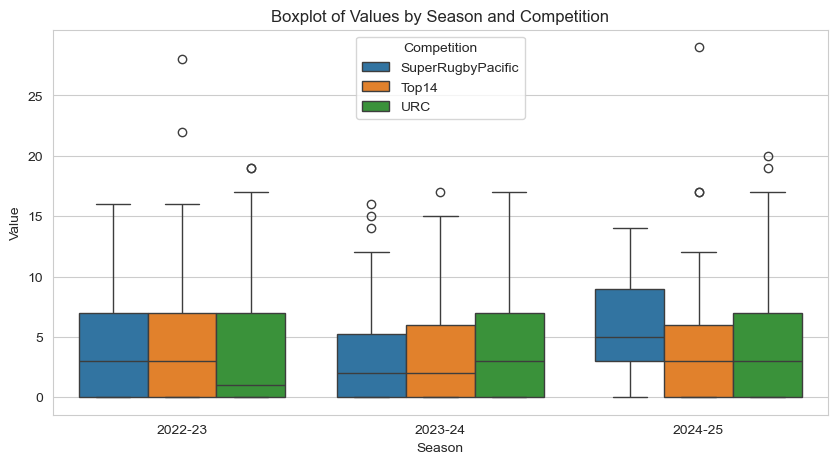

In [21]:
# Convert data into a DataFrame for visualization
plot_data = []
for competition, all_seasons in max_lead_for_losing_sides.items():
    for season, values in all_seasons.items():
        for value in values:
            plot_data.append({"Competition": competition, "Season": season, "Value": value})

df_plot = pd.DataFrame(plot_data)

# Set plot style
sns.set_style("whitegrid")

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x="Season", y="Value", hue="Competition", data=df_plot)
plt.title("Boxplot of Values by Season and Competition")

min_val = int(df_plot["Value"].min())
max_val = int(df_plot["Value"].max())
plt.yticks(range(0, max_val + 1, 5))

plt.xlabel("Season")
plt.ylabel("Value")
plt.legend(title="Competition")
plt.show()


In [22]:
for comp in comps:
    print(f"\n{comp}")
    for s in seasons:
        season = f"20{s-1}-{s}"
        print(f"\n{season}")

        nb_games = len(max_lead_for_losing_sides[comp][season])
        nb_above_10 = 0
        nb_above_20 = 0

        for g in range(0,nb_games):
            
            if max_lead_for_losing_sides[comp][season][g]>=10:
                nb_above_10+=1

            if max_lead_for_losing_sides[comp][season][g]>=20:
                nb_above_20+=1

        print("Total games: ",nb_games)
        print(f"Games finishing with a reverse lead of 10+: {nb_above_10} ({round(nb_above_10/nb_games*100,2)}%)")
        print(f"Games finishing with a reverse lead of 20+: {nb_above_20} ({round(nb_above_20/nb_games*100,2)}%)")



SuperRugbyPacific

2022-23
Total games:  84
Games finishing with a reverse lead of 10+: 12 (14.29%)
Games finishing with a reverse lead of 20+: 0 (0.0%)

2023-24
Total games:  84
Games finishing with a reverse lead of 10+: 9 (10.71%)
Games finishing with a reverse lead of 20+: 0 (0.0%)

2024-25
Total games:  25
Games finishing with a reverse lead of 10+: 6 (24.0%)
Games finishing with a reverse lead of 20+: 0 (0.0%)

Top14

2022-23
Total games:  182
Games finishing with a reverse lead of 10+: 25 (13.74%)
Games finishing with a reverse lead of 20+: 2 (1.1%)

2023-24
Total games:  182
Games finishing with a reverse lead of 10+: 23 (12.64%)
Games finishing with a reverse lead of 20+: 0 (0.0%)

2024-25
Total games:  105
Games finishing with a reverse lead of 10+: 9 (8.57%)
Games finishing with a reverse lead of 20+: 1 (0.95%)

URC

2022-23
Total games:  144
Games finishing with a reverse lead of 10+: 21 (14.58%)
Games finishing with a reverse lead of 20+: 0 (0.0%)

2023-24
Total games:  1

Done.